In [ ]:
#Importing matpltlib to visualize the learning curve 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Importinfg the models
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [ ]:
#Importing necessary layers
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout

In [ ]:
#Importing datasets
from tensorflow.keras.datasets import cifar10, cifar100, fashion_mnist

In [ ]:
#Loading the datasets
def load_cifar10():
  return cifar10.load_data()

def load_cifar100():
  return cifar10.load_data()

In [ ]:
#Normalizing pixel values 
def normalize_image_pixels(x):
  return x.astype('float32')/255.0

In [ ]:
from tensorflow.keras.utils import to_categorical
#One hot encode the labels
def one_hot_encode(y, num_classes):
  return to_categorical(y,num_classes=num_classes)

In [ ]:
#Base initializing the models 
def model_initialization(input_shape):
  Xception_model = Xception(weights='imagenet', include_top=False, input_shape=(71,71,3))
  ResNet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
  VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
  return [Xception_model, ResNet_model, VGG_model]

In [ ]:
#Convert a 2D into an 3D image if required for a dataset
def image_to_3d(x):
  return tf.expand_dims(x,axis=-1)

In [ ]:
#Function to freeze the layers of a model - parameters won't get updated during the training
def freeze_layer_training(model):
  for layer in model.layers[:-2]:
    layer.trainable = False

In [ ]:
#Add a custom classification head on top of the base model and compile the model
# We wanted to use GPU for faster and efficient training therefore we are using Mirrored Strategy that helps us utilize all the GPUs available
def model_creation_and_compile(num_classes, input_shape, freeze):
    models = []
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
      for model in model_initialization(input_shape):
        if freeze:
          freeze_layer_training(model)
        x = GlobalAveragePooling2D()(model.output)
        x = Dropout(0.5)(x)
        x = Dense(num_classes, activation='softmax')(x)  
        model = Model(inputs=model.input, outputs=x)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        models.append(model)
    return models

In [ ]:
#Training and testing of the model
def train_and_evaluate(model, x_train, y_train, x_test, y_test, epochs, batch_size):
  print('............. Training and Testing............')
  #Training the model
  history = model.fit(x_train, y_train, validation_split = 0.33, batch_size=batch_size, epochs=epochs)
  #Plotting model's learning curves
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show() 
  # Evaluate model on test dataset
  loss, accuracy = model.evaluate(x_test,y_test)
  # Print accuracy score
  print("Accuracy on test dataset: {:.2f}%".format(accuracy * 100))

In [ ]:
num_classes = {'cifar10':10, 'cifar100':100}
input_shape = {'cifar10':(32,32,3), 'cifar100':(32,32,3)}

#Loading the datasets

(cifar10_xtrain,cifar10_ytrain),(cifar10_xtest,cifar10_ytest) = load_cifar10() 
(cifar100_xtrain,cifar100_ytrain),(cifar100_xtest,cifar100_ytest) = load_cifar100()  

In [ ]:
#Normalizing the image pixels
cifar10_xtrain = normalize_image_pixels(cifar10_xtrain)
cifar10_xtest = normalize_image_pixels(cifar10_xtest)
cifar100_xtrain = normalize_image_pixels(cifar100_xtrain)
cifar100_xtest = normalize_image_pixels(cifar100_xtest)

In [ ]:
#One hot encoding the labels of the images
cifar10_ytrain = one_hot_encode(cifar10_ytrain, num_classes['cifar10'])
cifar10_ytest = one_hot_encode(cifar10_ytest, num_classes['cifar10'])
cifar100_ytrain = one_hot_encode(cifar100_ytrain, num_classes['cifar100'])
cifar100_ytest = one_hot_encode(cifar100_ytest, num_classes['cifar100'])

In [ ]:
#Model initilization and compliation 

# freeze variable controls whether we want Vanilla FT or Transfer Learning
freeze = True
models_cifar10 = model_creation_and_compile(num_classes['cifar10'], input_shape['cifar10'], freeze) 
models_cifar100 = model_creation_and_compile(num_classes['cifar100'], input_shape['cifar100'], freeze)

CIFAR10 Dataset


............. Training and Testing............
Epoch 1/5
524/524 [==============================] - 37s 60ms/step - loss: 1.2799 - accuracy: 0.5879 - val_loss: 1.0353 - val_accuracy: 0.6668
Epoch 2/5
524/524 [==============================] - 29s 55ms/step - loss: 1.0596 - accuracy: 0.6527 - val_loss: 0.9691 - val_accuracy: 0.6881
Epoch 3/5
524/524 [==============================] - 28s 54ms/step - loss: 1.0194 - accuracy: 0.6644 - val_loss: 0.9438 - val_accuracy: 0.6946
Epoch 4/5
524/524 [==============================] - 28s 54ms/step - loss: 0.9852 - accuracy: 0.6761 - val_loss: 0.9297 - val_accuracy: 0.7001
Epoch 5/5
524/524 [==============================] - 28s 54ms/step - loss: 0.9832 - accuracy: 0.6757 - val_loss: 0.9255 - val_accuracy: 0.7002


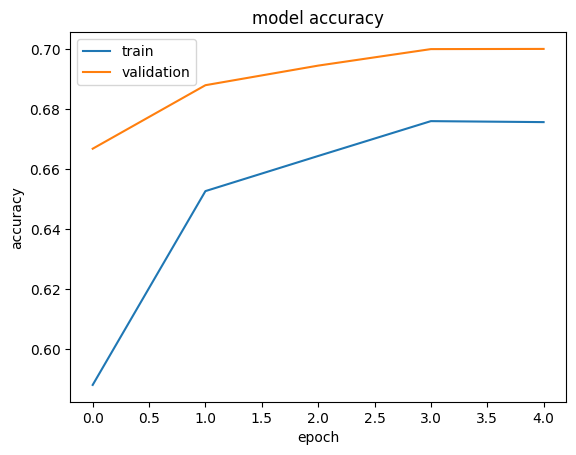

313/313 [==============================] - 8s 23ms/step - loss: 0.9432 - accuracy: 0.6938
Accuracy on test dataset: 69.38%
............. Training and Testing............
Epoch 1/5
524/524 [==============================] - 18s 26ms/step - loss: 2.4306 - accuracy: 0.1578 - val_loss: 2.0965 - val_accuracy: 0.2107
Epoch 2/5
524/524 [==============================] - 11s 20ms/step - loss: 2.1522 - accuracy: 0.2063 - val_loss: 2.0273 - val_accuracy: 0.2857
Epoch 3/5
524/524 [==============================] - 11s 21ms/step - loss: 2.1224 - accuracy: 0.2214 - val_loss: 1.9977 - val_accuracy: 0.2813
Epoch 4/5
524/524 [==============================] - 11s 20ms/step - loss: 2.1149 - accuracy: 0.2222 - val_loss: 2.0142 - val_accuracy: 0.2836
Epoch 5/5
524/524 [==============================] - 12s 23ms/step - loss: 2.1094 - accuracy: 0.2248 - val_loss: 2.0092 - val_accuracy: 0.2760


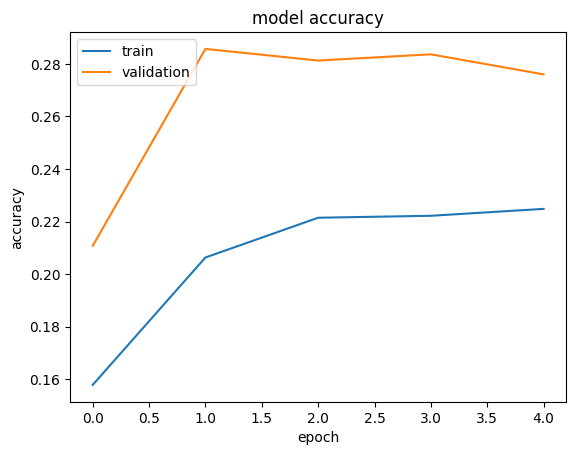

313/313 [==============================] - 5s 13ms/step - loss: 1.9971 - accuracy: 0.2776
Accuracy on test dataset: 27.76%
............. Training and Testing............
Epoch 1/5
524/524 [==============================] - 15s 24ms/step - loss: 1.4763 - accuracy: 0.4876 - val_loss: 1.1879 - val_accuracy: 0.5854
Epoch 2/5
524/524 [==============================] - 13s 25ms/step - loss: 1.2747 - accuracy: 0.5530 - val_loss: 1.1130 - val_accuracy: 0.6115
Epoch 3/5
524/524 [==============================] - 12s 22ms/step - loss: 1.2052 - accuracy: 0.5785 - val_loss: 1.0773 - val_accuracy: 0.6188
Epoch 4/5
524/524 [==============================] - 13s 25ms/step - loss: 1.1760 - accuracy: 0.5900 - val_loss: 1.0588 - val_accuracy: 0.6268
Epoch 5/5
524/524 [==============================] - 11s 21ms/step - loss: 1.1433 - accuracy: 0.5993 - val_loss: 1.0440 - val_accuracy: 0.6370


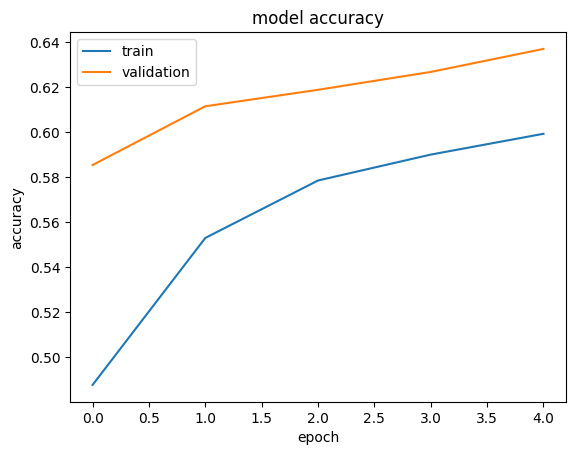

313/313 [==============================] - 4s 10ms/step - loss: 1.0524 - accuracy: 0.6297
Accuracy on test dataset: 62.97%


CIFAR100 Dataset


............. Training and Testing............
Epoch 1/5
524/524 [==============================] - 35s 60ms/step - loss: 1.4093 - accuracy: 0.5792 - val_loss: 1.0283 - val_accuracy: 0.6782
Epoch 2/5
524/524 [==============================] - 29s 55ms/step - loss: 1.0657 - accuracy: 0.6509 - val_loss: 0.9669 - val_accuracy: 0.6935
Epoch 3/5
524/524 [==============================] - 28s 53ms/step - loss: 1.0192 - accuracy: 0.6656 - val_loss: 0.9357 - val_accuracy: 0.7007
Epoch 4/5
524/524 [==============================] - 28s 54ms/step - loss: 0.9943 - accuracy: 0.6720 - val_loss: 0.9358 - val_accuracy: 0.6937
Epoch 5/5
524/524 [==============================] - 30s 57ms/step - loss: 0.9892 - accuracy: 0.6696 - val_loss: 0.9202 - val_accuracy: 0.7017


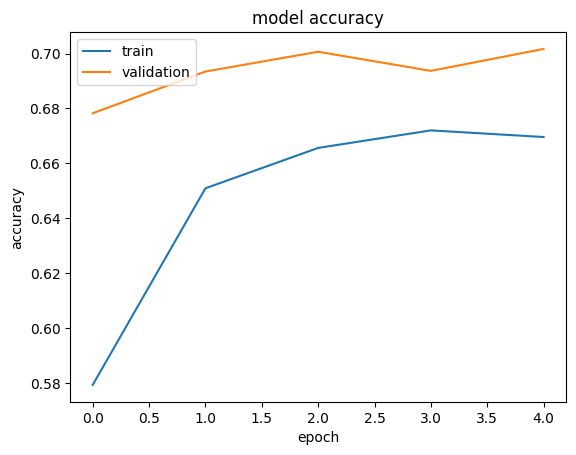

313/313 [==============================] - 7s 22ms/step - loss: 0.9383 - accuracy: 0.6936
Accuracy on test dataset: 69.36%
............. Training and Testing............
Epoch 1/5
524/524 [==============================] - 18s 25ms/step - loss: 2.4431 - accuracy: 0.1578 - val_loss: 2.1028 - val_accuracy: 0.2134
Epoch 2/5
524/524 [==============================] - 11s 21ms/step - loss: 2.1543 - accuracy: 0.2064 - val_loss: 2.0277 - val_accuracy: 0.2816
Epoch 3/5
524/524 [==============================] - 11s 20ms/step - loss: 2.1248 - accuracy: 0.2189 - val_loss: 2.0437 - val_accuracy: 0.2620
Epoch 4/5
524/524 [==============================] - 10s 20ms/step - loss: 2.1102 - accuracy: 0.2222 - val_loss: 2.0418 - val_accuracy: 0.2508
Epoch 5/5
524/524 [==============================] - 11s 20ms/step - loss: 2.1054 - accuracy: 0.2295 - val_loss: 1.9991 - val_accuracy: 0.2713


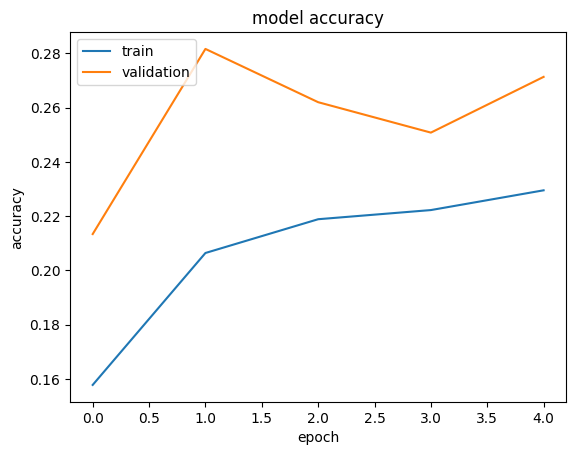

313/313 [==============================] - 4s 14ms/step - loss: 1.9876 - accuracy: 0.2814
Accuracy on test dataset: 28.14%
............. Training and Testing............
Epoch 1/5
524/524 [==============================] - 13s 23ms/step - loss: 1.4807 - accuracy: 0.4936 - val_loss: 1.1783 - val_accuracy: 0.5898
Epoch 2/5
524/524 [==============================] - 11s 21ms/step - loss: 1.2528 - accuracy: 0.5590 - val_loss: 1.1049 - val_accuracy: 0.6124
Epoch 3/5
524/524 [==============================] - 11s 21ms/step - loss: 1.1920 - accuracy: 0.5827 - val_loss: 1.0761 - val_accuracy: 0.6222
Epoch 4/5
524/524 [==============================] - 11s 22ms/step - loss: 1.1534 - accuracy: 0.5958 - val_loss: 1.0757 - val_accuracy: 0.6193
Epoch 5/5
524/524 [==============================] - 13s 25ms/step - loss: 1.1262 - accuracy: 0.6056 - val_loss: 1.0289 - val_accuracy: 0.6434


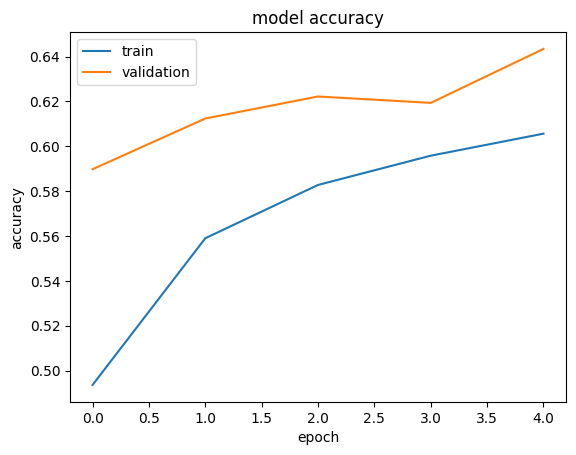

313/313 [==============================] - 3s 10ms/step - loss: 1.0390 - accuracy: 0.6331
Accuracy on test dataset: 63.31%


In [ ]:
#Actual Training and Evaluation

#Change the number of epochs and batch_size to test model on different configurations
epochs=5
batch_size=64

print('CIFAR10 Dataset')
print('\n')
for i in range(len(models_cifar10)):
  if i==0:
      # Resizing the images because the minimum image size required in Xception is 71x71
    train_and_evaluate(models_cifar10[i], tf.image.resize(cifar10_xtrain, size=(71, 71)),cifar10_ytrain,tf.image.resize(cifar10_xtest, size=(71, 71)),cifar10_ytest, epochs, batch_size)
  else:
    train_and_evaluate(models_cifar10[i], cifar10_xtrain,cifar10_ytrain,cifar10_xtest,cifar10_ytest, epochs, batch_size)

exit()

print('\n')
print('CIFAR100 Dataset')
print('\n')
for i in range(len(models_cifar100)):
  if i==0:
    train_and_evaluate(models_cifar100[i],  tf.image.resize(cifar100_xtrain, size=(71, 71)),cifar100_ytrain, tf.image.resize(cifar100_xtest, size=(71, 71)),cifar100_ytest, epochs, batch_size)
  else:
    train_and_evaluate(models_cifar100[i], cifar100_xtrain,cifar100_ytrain,cifar100_xtest,cifar100_ytest, epochs, batch_size)